In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import numpy.matlib
import theano.tensor as tt
import warnings

from sklearn import preprocessing
from theano import shared
from scipy.special import expit as logistic
from scipy.special import softmax
from scipy.stats import betabinom
from matplotlib.patches import Ellipse, transforms

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
az.style.use('arviz-darkgrid')

In [3]:
RANDOM_SEED = 42
np.random.seed(42)

In [4]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.9.2
ArviZ 0.9.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



### 1. The data in data(NWOGrants) are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012 (see van der Lee and Ellemers doi:10.1073/pnas.1510159112). These data have a very similar structure to the UCBAdmit data discussed in Chapter 11.

### I want you to consider a similar question: What are the total and indirect causal effects of gender on grant awards? Consider a mediation path (a pipe) through dis- cipline. Draw the corresponding DAG and then use one or more binomial GLMs to answer the question.

### What is your causal interpretation? If NWO’s goal is to equalize rates of funding between the genders, what type of intervention would be most effective?

In [5]:
df = pd.read_csv('Data/NWOGrants.csv', ';')
df

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18
5,Physics,f,9,2
6,Humanities,m,230,33
7,Humanities,f,166,32
8,Technical sciences,m,189,30
9,Technical sciences,f,62,13


G is gender, D is discipline, and A is award. The direct causal effect of gender is the path G → A. The total effect includes that path and the indirect path G → D → A. 

In [6]:
awards = df['awards'].values
apps = df['applications'].values
gid = pd.Categorical(df['gender']).codes

In [7]:
# define model: award ~ gender 
with pm.Model() as m6_1:
    
    # fixed priors
    a = pm.Normal('a', mu=-1., sd=1.0, shape=gid.max()+1)
    
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a[gid]))
    
    # likelihood
    A = pm.Binomial('A', p=p, n=apps, observed=awards)
    
    trace_m6_1 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m6_1 = az.from_pymc3(trace_m6_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [8]:
# show model summary
varnames = ['~p']
az.summary(idata_m6_1, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],-1.74,0.08,-1.86,-1.61
a[1],-1.53,0.07,-1.64,-1.43


Gender 1 here is male and 2 is female. So males have higher rates of award, on average. How big is the difference? 

In [9]:
post = idata_m6_1.posterior

In [10]:
diff = logistic(post['a'].sel(a_dim_0=1).stack(sample=('chain', 'draw')).to_pandas().values) - logistic(post['a'].sel(a_dim_0=0).stack(sample=('chain', 'draw')).to_pandas().values)
az.summary(diff, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
x,0.03,0.01,0.0,0.05


Now for the direct influence of gender, we condition on discipline as well:

In [11]:
disc = pd.Categorical(df['discipline']).codes

In [12]:
# define model: award ~ gender + discipline
with pm.Model() as m6_1:
    
    # fixed priors
    a = pm.Normal('a', mu=-1., sd=1.0, shape=gid.max()+1)
    d = pm.Normal('d', mu=0., sd=1.0, shape=disc.max()+1)
    
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a[gid] + d[disc]))
    
    # likelihood
    A = pm.Binomial('A', p=p, n=apps, observed=awards)
    
    trace_m6_2 = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_m6_2 = az.from_pymc3(trace_m6_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
# show model summary
varnames = ['~p']
az.summary(idata_m6_2, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],-1.47,0.32,-1.98,-0.94
a[1],-1.34,0.32,-1.82,-0.80
d[0],0.32,0.36,-0.27,0.90
d[1],-0.01,0.34,-0.56,0.53
d[2],-0.24,0.34,-0.79,0.29
d[3],-0.28,0.36,-0.84,0.30
d[4],-0.34,0.33,-0.89,0.18
d[5],-0.02,0.36,-0.60,0.56
d[6],0.29,0.39,-0.35,0.88
d[7],-0.46,0.33,-1.03,0.02


In [14]:
post = idata_m6_2.posterior

In [15]:
diff_a = logistic(post['a'].sel(a_dim_0=1).stack(sample=('chain', 'draw')).to_pandas().values) - logistic(post['a'].sel(a_dim_0=0).stack(sample=('chain', 'draw')).to_pandas().values)
az.summary(diff_a, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
x,0.02,0.02,-0.0,0.05


If there is a direct influence of gender here, it is small, much smaller than before we accounted for discipline. Why? Because again the disciplines have different funding rates and women apply more to the disciplines with lower funding rates. But it would be hasty, I think, to conclude there are no other influences. There are after all lots of unmeasured confounds.

### 2. Suppose that the NWO Grants sample has an unobserved confound that influences both choice of discipline and the probability of an award. One example of such a confound could be the career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the grants. In other disciplines, scholars from all career stages compete. As a result, career stage influences discipline as well as the probability of being awarded a grant.

### Add these influences to your DAG from Problem 1. What happens now when you condition on discipline? Does it provide an un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your answer with the back-door criterion. Hint: This is structurally a lot like the grandparents-parents-children-neighborhoods example from a previous week.

### If you have trouble thinking this though, try simulating fake data, assuming your DAG is true. Then analyze it using the model from Problem 1. What do you conclude? Is it possible for gender to have a real direct causal influence but for a regression conditioning on both gender and discipline to suggest zero influence?

In [16]:
N = 1000
G = scipy.stats.bernoulli.rvs(p=0.5, size=N)
S = scipy.stats.bernoulli.rvs(p=0.5, size=N)
D = scipy.stats.bernoulli.rvs(p=logistic(G+S), size=N)
A = scipy.stats.bernoulli.rvs(p=logistic(0.25*G + D + 2*S - 2), size=N)

This code simulates 1000 applicants. There are 2 genders (G 0/1), 2 stages of career (S 0/1), and 2 disciplines (D 0/1). Discipline 1 is chosen more by gender 1 and career stage 1. So that could mean more by males and later stage of career. Then awards A have a consistent bias towards gender 1, and discipline 1 has a higher award rate, and stage 1 also a higher award rate. 

In [17]:
# define model: award ~ gender + discipline
with pm.Model() as m6_3:
    
    # fixed priors
    a = pm.Normal('a', mu=0., sd=1.0)
    d = pm.Normal('d', mu=0., sd=1.0)
    g = pm.Normal('g', mu=0., sd=1.0)
    
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a + d*D + g*G))
    
    # likelihood
    A_est = pm.Bernoulli('A_est', p=p, observed=A)
    
    trace_m6_3 = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_m6_3 = az.from_pymc3(trace_m6_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, d, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [18]:
# show model summary
varnames = ['~p']
az.summary(idata_m6_3, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-1.17,0.15,-1.40,-0.93
d,1.26,0.16,0.99,1.50
g,0.28,0.13,0.06,0.49


In [19]:
N = 1000
G = scipy.stats.bernoulli.rvs(p=0.5, size=N)
S = scipy.stats.bernoulli.rvs(p=0.5, size=N)
D = scipy.stats.bernoulli.rvs(p=logistic(2*G-S), size=N)
A = scipy.stats.bernoulli.rvs(p=logistic(0*G + D + S - 2), size=N)

In [20]:
# define model: award ~ gender + discipline
with pm.Model() as m6_4:
    
    # fixed priors
    a = pm.Normal('a', mu=0., sd=1.0)
    d = pm.Normal('d', mu=0., sd=1.0)
    g = pm.Normal('g', mu=0., sd=1.0)
    
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a + d*D + g*G))
    
    # likelihood
    A_est = pm.Bernoulli('A_est', p=p, observed=A)
    
    trace_m6_4 = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_m6_4 = az.from_pymc3(trace_m6_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, d, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [21]:
# show model summary
varnames = ['~p']
az.summary(idata_m6_4, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-1.40,0.13,-1.62,-1.20
d,0.77,0.16,0.50,1.02
g,0.18,0.16,-0.05,0.44


Now it looks like gender 1 has a consistent advantage, but in fact there is no advantage in the simulation.

### 3. The data in data(Primates301) were first introduced at the end of Chapter 7. In this problem, you will consider how brain size is associated with social learning. There are three parts.

### First, model the number of observations of social_learning for each species as a function of the log brain size. Use a Poisson distribution for the social_learning outcome variable. Interpret the resulting posterior.

### Second, some species are studied much more than others. So the number of re- ported instances of social_learning could be a product of research effort. Use the research_effort variable, specifically its logarithm, as an additional predic- tor variable. Interpret the coefficient for log research_effort. Does this model disagree with the previous one?

### Third, draw a DAG to represent how you think the variables social_learning, brain, and research_effort interact. Justify the DAG with the measured associations in the two models above (and any other models you used).

In [22]:
df = pd.read_csv('Data/Primates301.csv', ';')
df

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.00,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.00,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.40,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.90,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.40,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,Trachypithecus_pileatus,Trachypithecus,pileatus,NaN,297,67,0.0,5.0,103.64,11794.00,8.50,NaN,NaN,NaN,NaN,NaN
297,Trachypithecus_poliocephalus,Trachypithecus,poliocephalus,NaN,298,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.00,8.35,204.72,245.78,276.0,1113.70,450.50
299,Varecia_rubra,Varecia,rubra,NaN,300,68,NaN,NaN,31.08,3470.00,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df2 = df.dropna(subset=['social_learning', 'brain', 'research_effort'])
df2

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.00,NaN,106.15,276.0,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.0,7.40,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.90,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.0,7.40,NaN,NaN,NaN,NaN,NaN
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.10,185.42,495.60,300.0,1578.42,681.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,Trachypithecus_obscurus,Trachypithecus,obscurus,NaN,295,67,0.0,6.0,62.12,7056.0,10.00,146.63,362.93,300.0,NaN,509.56
295,Trachypithecus_phayrei,Trachypithecus,phayrei,NaN,296,67,0.0,16.0,72.84,7475.0,12.90,180.61,305.87,NaN,NaN,486.48
296,Trachypithecus_pileatus,Trachypithecus,pileatus,NaN,297,67,0.0,5.0,103.64,11794.0,8.50,NaN,NaN,NaN,NaN,NaN
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.0,8.35,204.72,245.78,276.0,1113.70,450.50


In [24]:
soc_learn = df2['social_learning'].values
log_brain = preprocessing.scale(np.log(df2['brain'].values))
log_effort = np.log(df2['research_effort'].values)

In [25]:
# define model: social_learning ~ log_brain
with pm.Model() as m6_5:
    
    # fixed priors
    a = pm.Normal('a', mu=0., sd=1.0)
    bB = pm.Normal('bB', mu=0., sd=0.5)
    
    # linear model
    lam = pm.Deterministic('lam', pm.math.invlogit(a + bB*log_brain))
    
    # likelihood
    Learning = pm.Poisson('Learning', mu=lam, observed=soc_learn)
    
    trace_m6_5 = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_m6_5 = az.from_pymc3(trace_m6_5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bB, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [26]:
# show model summary
varnames = ['~lam']
az.summary(idata_m6_5, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.38,0.33,0.82,1.88
bB,2.03,0.23,1.65,2.39


Brain size seems to be strongly associated with social learning observations.

In [27]:
post = idata_m6_5.posterior

In [28]:
with m6_5:
    post = pm.sample_posterior_predictive(
        trace_m6_5, random_seed=RANDOM_SEED
    )

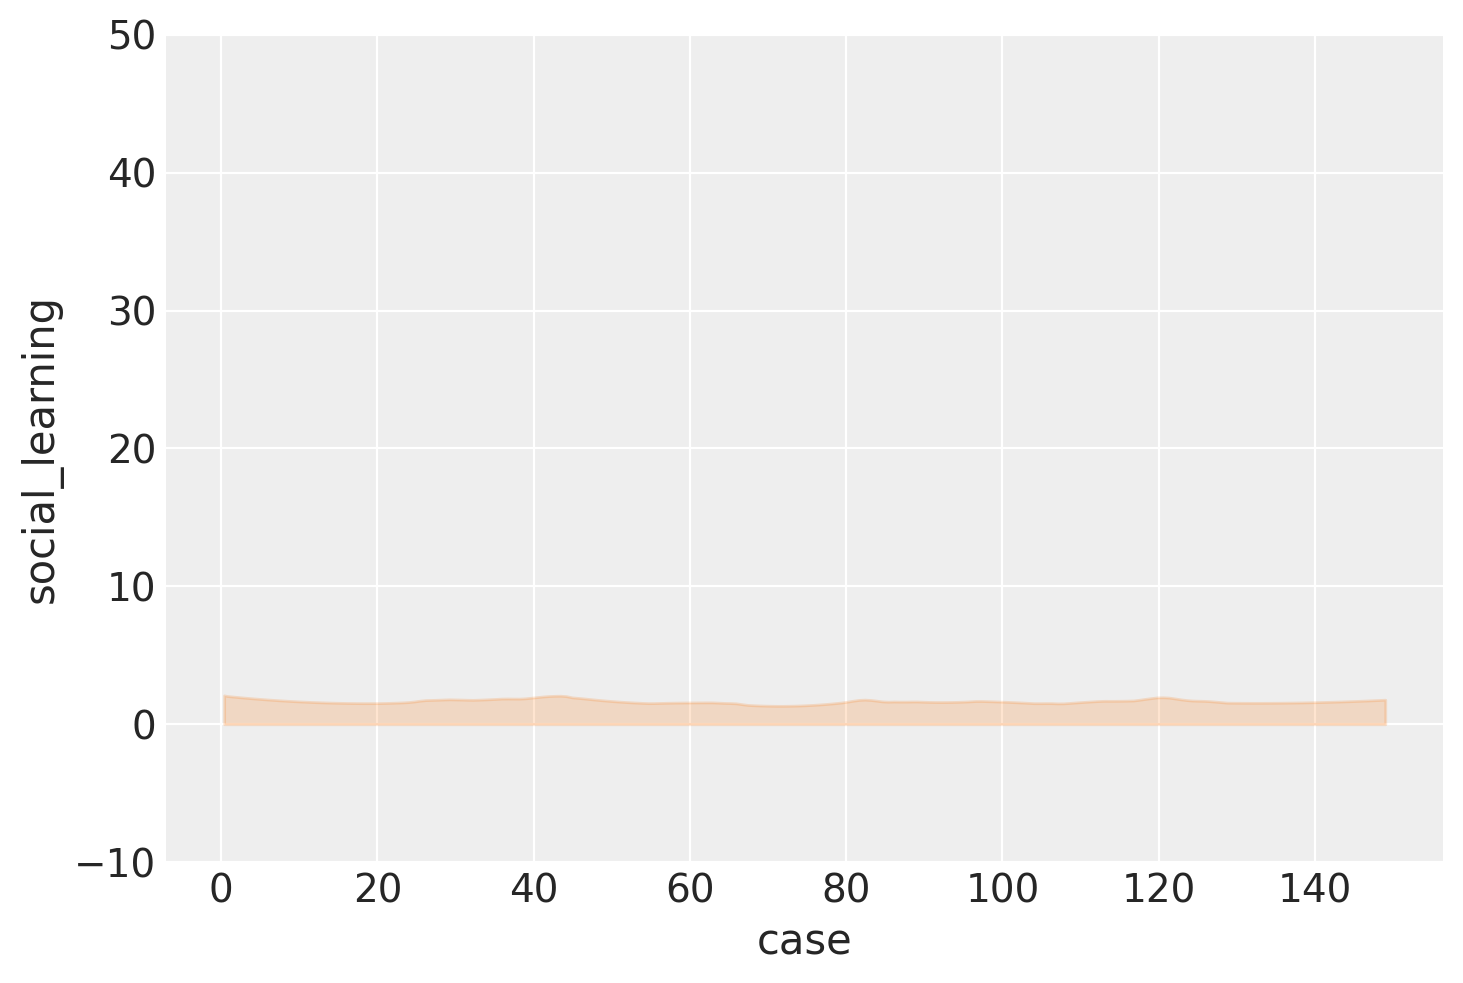

In [29]:
post_CI = az.hdi(post['Learning'], hdi_prob=0.89)
az.plot_hdi(range(150), post['Learning'],
            color='C1',
            hdi_prob = 0.89,
            fill_kwargs={'alpha': 0.2}
           );
plt.ylabel('social_learning', fontsize=15)
plt.xlabel('case', fontsize=15)
plt.ylim([-10, 50])
plt.show()

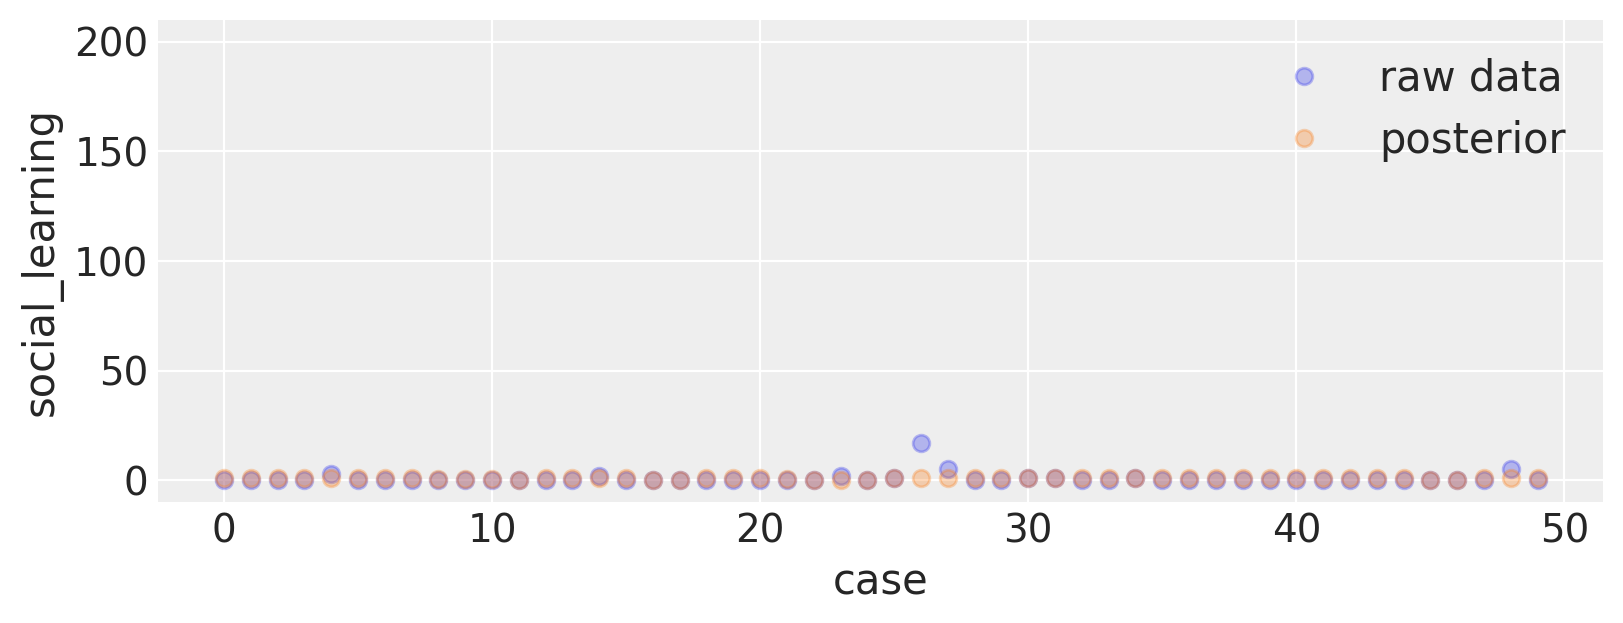

In [30]:
fig = plt.figure(figsize=(8, 3))
plt.plot(range(50), soc_learn[:50],'C0o', alpha=0.3, label='raw data')
plt.plot(range(50), post['Learning'].mean(0)[:50],'C1o', alpha=0.3, label='posterior')
plt.legend(fontsize=15)
plt.ylabel('social_learning', fontsize=15)
plt.xlabel('case', fontsize=15)
plt.ylim([-10, 210])
plt.show()

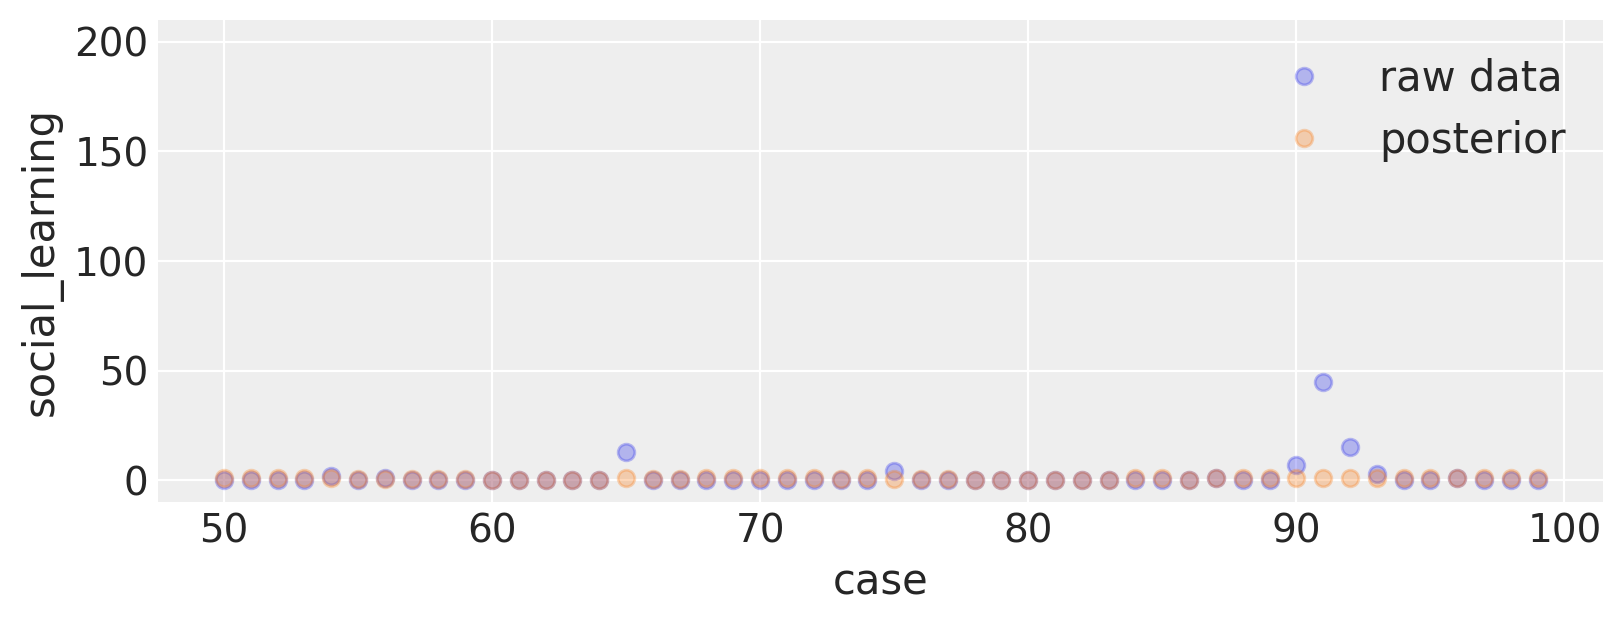

In [31]:
fig = plt.figure(figsize=(8, 3))
plt.plot(range(50,100), soc_learn[50:100],'C0o', alpha=0.3, label='raw data')
plt.plot(range(50,100), post['Learning'].mean(0)[50:100],'C1o', alpha=0.3, label='posterior')
plt.legend(fontsize=15)
plt.ylabel('social_learning', fontsize=15)
plt.xlabel('case', fontsize=15)
plt.ylim([-10, 210])
plt.show()

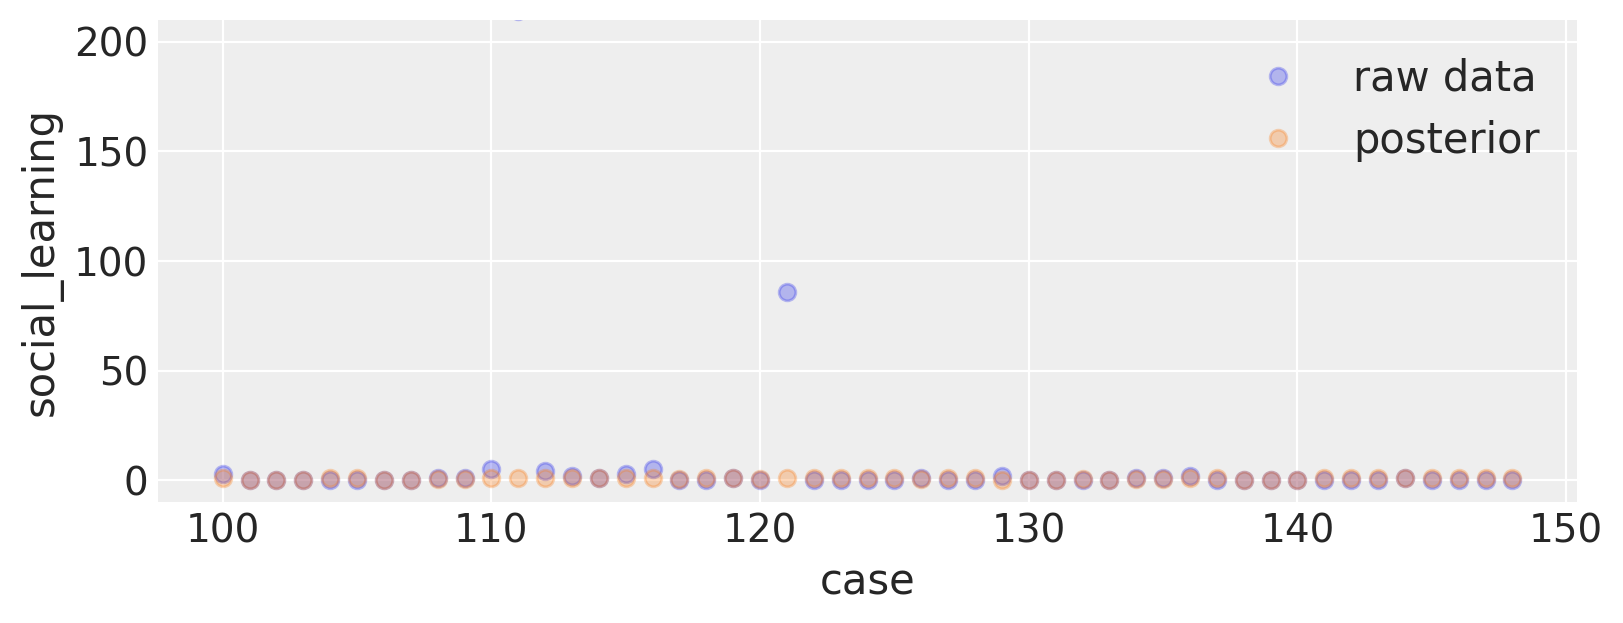

In [32]:
fig = plt.figure(figsize=(8, 3))
plt.plot(range(100, 149), soc_learn[100:149],'C0o', alpha=0.3, label='raw data')
plt.plot(range(100, 149), post['Learning'].mean(0)[100:149],'C1o', alpha=0.3, label='posterior')
plt.legend(fontsize=15)
plt.ylabel('social_learning', fontsize=15)
plt.xlabel('case', fontsize=15)
plt.ylim([-10, 210])
plt.show()

In [33]:
# define model: social_learning ~ log_brain + log_effort
with pm.Model() as m6_6:
    
    # fixed priors
    a = pm.Normal('a', mu=0., sd=1.0)
    bB = pm.Normal('bB', mu=0., sd=0.5)
    bE = pm.Normal('bE', mu=0., sd=0.5)
    
    # linear model
    lam = pm.Deterministic('lam', pm.math.invlogit(a + bB*log_brain + bE*log_effort))
    
    # likelihood
    Learning = pm.Poisson('Learning', mu=lam, observed=soc_learn)
    
    trace_m6_6 = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_m6_6 = az.from_pymc3(trace_m6_6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bE, bB, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [34]:
# show model summary
varnames = ['~lam']
az.summary(idata_m6_6, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-3.70,0.55,-4.59,-2.85
bB,1.05,0.26,0.63,1.45
bE,1.19,0.15,0.97,1.45


Brain size bB is still positively associated, but much less. Research effort be is strongly associated. To see how these models disagree, let’s use pointwise WAIC to see which cases each predicts well.

In [35]:
pm.compare({'m6_5': idata_m6_5, 
            'm6_6': idata_m6_6}, scale='deviance', ic='WAIC')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_6,0,3189.05,2.10996,0,1,2041.56,0,False,deviance
m6_5,1,3253.22,2.98246,64.1698,3.80836e-09,2039.66,10.9933,True,deviance


ncluding E reduced the association with B, which we would expect when we close the indirect path through E. If researchers choose to look for social learning in species with large brains, this leads to an exaggerated estimate of the association between brains and social learning.